In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Machine learning
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score


# Automated feature engineering
import featuretools as ft



In [2]:
from platform import python_version
print(python_version())
print("Feature Tools version:", ft.__version__)

3.10.5
Feature Tools version: 1.11.1


In [3]:
data_2011 = pd.read_csv("salesdata_2011.csv")

In [4]:
data_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175,False
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325,False
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625,False


In [5]:
data_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375250 entries, 0 to 375249
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    375250 non-null  object 
 1   StockCode    375250 non-null  object 
 2   Description  375250 non-null  object 
 3   Quantity     375250 non-null  int64  
 4   InvoiceDate  375250 non-null  object 
 5   UnitPrice    375250 non-null  float64
 6   CustomerID   375250 non-null  float64
 7   Country      375250 non-null  object 
 8   total        375250 non-null  float64
 9   cancelled    375250 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 26.1+ MB


In [6]:
labels = pd.read_csv("labels.csv")

In [7]:
labels.head(5)

,CustomerID,time,label
0,13313,3/1/2011,0
1,18097,3/1/2011,0
2,16656,3/1/2011,1
3,16875,3/1/2011,0
4,13094,3/1/2011,0


In [8]:
labels.shape

(28133, 3)

In [9]:
labels.label.value_counts(normalize=True)

0    0.829453
1    0.170547
Name: label, dtype: float64

In [10]:
data_2011['CustomerID'].nunique()

4244

In [11]:
labels['CustomerID'].nunique()

4197

In [12]:
labels.CustomerID.nunique()

4197

In [13]:
data_2011.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,375250.0,12.252296,258.180877,-80995.00,2.0000,5.0000,12.0000,80995.00
UnitPrice,375250.0,5.762031,119.054102,0.00,2.0625,3.2175,6.1875,64300.50
CustomerID,375250.0,15265.136168,1710.927381,12346.00,13901.0000,15108.0000,16767.0000,18287.00
total,375250.0,33.972397,733.803756,-277974.84,7.0125,19.3050,32.6700,277974.84


In [14]:
data_2011 = data_2011[(data_2011.Quantity>0) & (data_2011.UnitPrice>0) & (data_2011.total>0) ]

In [15]:
data_2011.CustomerID.nunique()

4219

In [16]:
data_2011.shape

(367022, 10)

In [17]:
data_2011.Description.nunique()

3784

In [18]:
data_2011.Country.nunique()

36

We now have our prediction problem all set. The next step is to start making features we can use in a machine learning model.

# Featuretools Implementation

- The first step in Featuretools is to create an `EntitySet` which will hold all of our data and the relationships between the multiple tables (which we'll create shortly). 
- Initially we'll add the entire `data` as an `entity` to the set. 
- Since data has a `time_index`, we'll add that and specify the variable type of the product description.
<br>
- The `time_index` represents the first time the information in that row is known. 
- When we build features, Featuretools will use this `time_index` to filter data based on the cutoff time of the label. 
- We can't use any purchases from after the cutoff time of the label to make features for that label.

In [19]:
data_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175,False
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325,False
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325,False
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625,False


In [22]:
es = ft.EntitySet(id="Online Retail Logs")

# because there is no index
# a dummy id "purchases_index" will be created
es.add_dataframe( 
                dataframe_name=  "purchases",
                dataframe=data_2011,
                index="purchases_index",
                time_index = "InvoiceDate"
                )

es['purchases']


#ANOTHER EXAMPLE
#https://featuretools.alteryx.com/en/stable/generated/featuretools.EntitySet.html
#dataframes = {
#    "cards" : (card_df, "id"),
#    "transactions" : (transactions_df, "id", "transaction_time")
#}
#relationships = [("cards", "id", "transactions", "card_id")]
#ft.EntitySet("my-entity-set", dataframes, relationships)

,purchases_index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,cancelled
0,0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.1750,False
1,1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.3250,False
2,2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.3250,False
3,3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.3250,False
4,4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.6250,False
...,...,...,...,...,...,...,...,...,...,...,...
367017,367017,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,1.4025,12680.0,France,16.8300,False
367018,367018,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,3.4650,12680.0,France,20.7900,False
367019,367019,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,6.8475,12680.0,France,27.3900,False
367020,367020,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,6.8475,12680.0,France,27.3900,False


### Normalizing Entities

In order to create new tables out of the original table, we can normalize this `entity`. This creates new tables by creating a unique row for every variable that we pass in, such as the customer or the product.

The code below creates a new entity for the `products` where each row contains one product and the columns describe the product. 

In [23]:
# create a new "products" entity
es.normalize_dataframe(new_dataframe_name="products",
                    base_dataframe_name="purchases",
                    index="StockCode",
                    additional_columns=["Description","UnitPrice"])

Entityset: Online Retail Logs
  DataFrames:
    purchases [Rows: 367022, Columns: 9]
    products [Rows: 3596, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode

In [24]:
es['products']

,StockCode,Description,UnitPrice,first_purchases_time
22386,22386,JUMBO BAG PINK POLKADOT,3.2175,2011-01-04 10:00:00
21499,21499,BLUE POLKADOT WRAP,0.6930,2011-01-04 10:00:00
21498,21498,RED RETROSPOT WRAP,0.6930,2011-01-04 10:00:00
22379,22379,RECYCLING BAG RETROSPOT,3.4650,2011-01-04 10:00:00
20718,20718,RED RETROSPOT SHOPPER BAG,2.0625,2011-01-04 10:00:00
...,...,...,...,...
90214U,90214U,"LETTER ""U"" BLING KEY RING",0.4785,2011-12-05 15:48:00
90214W,90214W,"LETTER ""W"" BLING KEY RING",0.4785,2011-12-05 15:48:00
90214Z,90214Z,"LETTER ""Z"" BLING KEY RING",0.4785,2011-12-05 15:48:00
90089,90089,PINK CRYSTAL SKULL PHONE CHARM,0.3135,2011-12-06 11:58:00


- The `first_purchases_time` is automatically created because the `purchases` table has a time index. This represents the first time the product appears in the purchase data. Again, Featuretools will filter data from this table for each label so that we only build valid features. 

- We can use this table to create new features; the products table is a parent of the `purchases` table with the linking variable `product_id`. For each product in `products`, there can be multiple purchases of that product in `purchases`. 

### Additional Tables

We'll repeat the process to create tables for both the `customers` and the `orders`. `normalize_entity` automatically creates the relationships and time index so we don't have to do that ourselves. If we want to include any other additional variables in the table, we can pass those in. These variables must be unique to the object that we are normalizing for. As an example, each order comes from one country, so we can include that as additional variables when creating the `orders` table. However, the description is not unique to an order, so that should not be a variable that appears in the orders table.

In [25]:
es['purchases']

,purchases_index,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,total,cancelled
0,0,539993,22386,10,2011-01-04 10:00:00,13313.0,United Kingdom,32.1750,False
1,1,539993,21499,25,2011-01-04 10:00:00,13313.0,United Kingdom,17.3250,False
2,2,539993,21498,25,2011-01-04 10:00:00,13313.0,United Kingdom,17.3250,False
3,3,539993,22379,5,2011-01-04 10:00:00,13313.0,United Kingdom,17.3250,False
4,4,539993,20718,10,2011-01-04 10:00:00,13313.0,United Kingdom,20.6250,False
...,...,...,...,...,...,...,...,...,...
367017,367017,581587,22613,12,2011-12-09 12:50:00,12680.0,France,16.8300,False
367018,367018,581587,22899,6,2011-12-09 12:50:00,12680.0,France,20.7900,False
367019,367019,581587,23254,4,2011-12-09 12:50:00,12680.0,France,27.3900,False
367020,367020,581587,23255,4,2011-12-09 12:50:00,12680.0,France,27.3900,False


In [26]:
# create a new "customers" entity based on the orders entity
es.normalize_dataframe(new_dataframe_name="customers",
                    base_dataframe_name="purchases",
                    index="CustomerID")

# create a new "orders" entity
es.normalize_dataframe(new_dataframe_name="orders",
                    base_dataframe_name="purchases",
                    index="InvoiceNo",
                    additional_columns=["Country",'cancelled'])

es

Entityset: Online Retail Logs
  DataFrames:
    purchases [Rows: 367022, Columns: 7]
    products [Rows: 3596, Columns: 4]
    customers [Rows: 4219, Columns: 2]
    orders [Rows: 17132, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode
    purchases.CustomerID -> customers.CustomerID
    purchases.InvoiceNo -> orders.InvoiceNo

In [27]:
es['orders']

,InvoiceNo,Country,cancelled,first_purchases_time
539993,539993,United Kingdom,False,2011-01-04 10:00:00
540001,540001,United Kingdom,False,2011-01-04 10:22:00
540002,540002,United Kingdom,False,2011-01-04 10:23:00
540003,540003,United Kingdom,False,2011-01-04 10:37:00
540004,540004,United Kingdom,False,2011-01-04 10:37:00
...,...,...,...,...
581583,581583,United Kingdom,False,2011-12-09 12:23:00
581584,581584,United Kingdom,False,2011-12-09 12:25:00
581585,581585,United Kingdom,False,2011-12-09 12:31:00
581586,581586,United Kingdom,False,2011-12-09 12:49:00


In [28]:
es['customers']

,CustomerID,first_purchases_time
13313.0,13313.0,2011-01-04 10:00:00
18097.0,18097.0,2011-01-04 10:22:00
16656.0,16656.0,2011-01-04 10:23:00
16875.0,16875.0,2011-01-04 10:37:00
13094.0,13094.0,2011-01-04 10:37:00
...,...,...
13436.0,13436.0,2011-12-08 10:33:00
15520.0,15520.0,2011-12-08 10:58:00
13298.0,13298.0,2011-12-08 13:11:00
14569.0,14569.0,2011-12-08 14:58:00


# Deep Feature Synthesis 

Now that our `EntitySet` is defined with the proper relationships between tables, we can perform [deep feature synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf) to generate 100s or 1000s of features. We can theoretically make features for any entity, but since our objective is to classify customer spending, we'll make features for each customer for each month. 

In [29]:
labels.head()

,CustomerID,time,label
0,13313,3/1/2011,0
1,18097,3/1/2011,0
2,16656,3/1/2011,1
3,16875,3/1/2011,0
4,13094,3/1/2011,0


In [30]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28133 entries, 0 to 28132
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  28133 non-null  int64 
 1   time        28133 non-null  object
 2   label       28133 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 659.5+ KB


In [31]:
labels.label.value_counts()

0    23335
1     4798
Name: label, dtype: int64

In [32]:
es

Entityset: Online Retail Logs
  DataFrames:
    purchases [Rows: 367022, Columns: 7]
    products [Rows: 3596, Columns: 4]
    customers [Rows: 4219, Columns: 2]
    orders [Rows: 17132, Columns: 4]
  Relationships:
    purchases.StockCode -> products.StockCode
    purchases.CustomerID -> customers.CustomerID
    purchases.InvoiceNo -> orders.InvoiceNo

In [33]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_dataframe_name='customers',
                                    n_jobs = -1,
                                   max_depth = 3)

feature_matrix.head()

EntitySet scattered to 6 workers in 6 seconds


,COUNT(purchases),MAX(purchases.Quantity),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.total),MODE(purchases.InvoiceNo),MODE(purchases.StockCode),NUM_UNIQUE(purchases.InvoiceNo),...,SUM(purchases.products.MEAN(purchases.total)),SUM(purchases.products.MIN(purchases.Quantity)),SUM(purchases.products.MIN(purchases.total)),SUM(purchases.products.NUM_UNIQUE(purchases.InvoiceNo)),SUM(purchases.products.SKEW(purchases.Quantity)),SUM(purchases.products.SKEW(purchases.total)),SUM(purchases.products.STD(purchases.Quantity)),SUM(purchases.products.STD(purchases.total)),SUM(purchases.products.SUM(purchases.Quantity)),SUM(purchases.products.SUM(purchases.total))
CustomerID,,,,,,,,,,,,,,,,,,,,,
13313.0,78,36.0,98.010,10.910256,32.901000,4.0,8.316,539993,22302,5,...,3546.659670,111.0,288.9645,44662.0,585.881749,534.174299,2698.150662,7906.671588,794461.0,2.496841e+06
18097.0,99,96.0,178.992,14.202020,41.331333,2.0,8.316,553685,21231,5,...,4041.132254,171.0,546.6615,31177.0,780.963145,752.798210,3563.624711,9647.712251,517900.0,1.433781e+06
16656.0,69,480.0,831.600,123.159420,196.016174,2.0,16.632,555005,21704,14,...,3579.168359,72.0,279.4770,25793.0,420.337834,403.428131,2766.946255,6585.092559,377061.0,9.079188e+05
16875.0,112,24.0,65.670,9.544643,30.871647,1.0,11.484,569331,22767,5,...,4678.982270,113.0,644.3250,50146.0,810.002421,778.898736,2971.435462,9386.299093,663242.0,2.153522e+06
13094.0,21,144.0,251.856,72.571429,133.857429,18.0,87.615,553177,22791,11,...,1107.290949,21.0,49.5825,10964.0,94.434190,89.311842,773.864284,1776.121658,255640.0,6.627637e+05


In [35]:
feature_matrix.columns

Index(['COUNT(purchases)', 'MAX(purchases.Quantity)', 'MAX(purchases.total)',
       'MEAN(purchases.Quantity)', 'MEAN(purchases.total)',
       'MIN(purchases.Quantity)', 'MIN(purchases.total)',
       'MODE(purchases.InvoiceNo)', 'MODE(purchases.StockCode)',
       'NUM_UNIQUE(purchases.InvoiceNo)',
       ...
       'SUM(purchases.products.MEAN(purchases.total))',
       'SUM(purchases.products.MIN(purchases.Quantity))',
       'SUM(purchases.products.MIN(purchases.total))',
       'SUM(purchases.products.NUM_UNIQUE(purchases.InvoiceNo))',
       'SUM(purchases.products.SKEW(purchases.Quantity))',
       'SUM(purchases.products.SKEW(purchases.total))',
       'SUM(purchases.products.STD(purchases.Quantity))',
       'SUM(purchases.products.STD(purchases.total))',
       'SUM(purchases.products.SUM(purchases.Quantity))',
       'SUM(purchases.products.SUM(purchases.total))'],
      dtype='object', length=228)

In [36]:
print(feature_matrix.columns.to_list())

['COUNT(purchases)', 'MAX(purchases.Quantity)', 'MAX(purchases.total)', 'MEAN(purchases.Quantity)', 'MEAN(purchases.total)', 'MIN(purchases.Quantity)', 'MIN(purchases.total)', 'MODE(purchases.InvoiceNo)', 'MODE(purchases.StockCode)', 'NUM_UNIQUE(purchases.InvoiceNo)', 'NUM_UNIQUE(purchases.StockCode)', 'SKEW(purchases.Quantity)', 'SKEW(purchases.total)', 'STD(purchases.Quantity)', 'STD(purchases.total)', 'SUM(purchases.Quantity)', 'SUM(purchases.total)', 'DAY(first_purchases_time)', 'MONTH(first_purchases_time)', 'WEEKDAY(first_purchases_time)', 'YEAR(first_purchases_time)', 'MAX(purchases.products.UnitPrice)', 'MEAN(purchases.products.UnitPrice)', 'MIN(purchases.products.UnitPrice)', 'MODE(purchases.DAY(InvoiceDate))', 'MODE(purchases.MONTH(InvoiceDate))', 'MODE(purchases.WEEKDAY(InvoiceDate))', 'MODE(purchases.YEAR(InvoiceDate))', 'MODE(purchases.orders.Country)', 'MODE(purchases.products.Description)', 'NUM_UNIQUE(purchases.DAY(InvoiceDate))', 'NUM_UNIQUE(purchases.MONTH(InvoiceDate

In [37]:
feature_matrix.shape

(4219, 228)

In [38]:
feature_matrix['MODE(purchases.StockCode)'].value_counts()

POST     100
21034     69
20725     62
22423     60
20914     54
        ... 
22241      1
22257      1
22260      1
22265      1
10002      1
Name: MODE(purchases.StockCode), Length: 1090, dtype: int64

In [39]:
labels.shape

(28133, 3)

In [40]:
labels.columns

Index(['CustomerID', 'time', 'label'], dtype='object')

In [41]:
feature_matrix = feature_matrix.reset_index()

In [42]:
feature_matrix.head()

,CustomerID,COUNT(purchases),MAX(purchases.Quantity),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.total),MODE(purchases.InvoiceNo),MODE(purchases.StockCode),...,SUM(purchases.products.MEAN(purchases.total)),SUM(purchases.products.MIN(purchases.Quantity)),SUM(purchases.products.MIN(purchases.total)),SUM(purchases.products.NUM_UNIQUE(purchases.InvoiceNo)),SUM(purchases.products.SKEW(purchases.Quantity)),SUM(purchases.products.SKEW(purchases.total)),SUM(purchases.products.STD(purchases.Quantity)),SUM(purchases.products.STD(purchases.total)),SUM(purchases.products.SUM(purchases.Quantity)),SUM(purchases.products.SUM(purchases.total))
0,13313.0,78,36.0,98.010,10.910256,32.901000,4.0,8.316,539993,22302,...,3546.659670,111.0,288.9645,44662.0,585.881749,534.174299,2698.150662,7906.671588,794461.0,2.496841e+06
1,18097.0,99,96.0,178.992,14.202020,41.331333,2.0,8.316,553685,21231,...,4041.132254,171.0,546.6615,31177.0,780.963145,752.798210,3563.624711,9647.712251,517900.0,1.433781e+06
2,16656.0,69,480.0,831.600,123.159420,196.016174,2.0,16.632,555005,21704,...,3579.168359,72.0,279.4770,25793.0,420.337834,403.428131,2766.946255,6585.092559,377061.0,9.079188e+05
3,16875.0,112,24.0,65.670,9.544643,30.871647,1.0,11.484,569331,22767,...,4678.982270,113.0,644.3250,50146.0,810.002421,778.898736,2971.435462,9386.299093,663242.0,2.153522e+06
4,13094.0,21,144.0,251.856,72.571429,133.857429,18.0,87.615,553177,22791,...,1107.290949,21.0,49.5825,10964.0,94.434190,89.311842,773.864284,1776.121658,255640.0,6.627637e+05


In [38]:
cols_remove = ['COUNT(purchases)', 'YEAR(first_purchases_time)', 'MODE(purchases.InvoiceNo)',
       'MODE(purchases.StockCode)']

In [39]:
feature_matrix2 = feature_matrix.drop(columns = cols_remove)
feature_matrix2.shape

(4219, 18)

In [40]:
feature_matrix2.head()

,CustomerID,MAX(purchases.Quantity),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.total),NUM_UNIQUE(purchases.InvoiceNo),NUM_UNIQUE(purchases.StockCode),SKEW(purchases.Quantity),SKEW(purchases.total),STD(purchases.Quantity),STD(purchases.total),SUM(purchases.Quantity),SUM(purchases.total),DAY(first_purchases_time),MONTH(first_purchases_time),WEEKDAY(first_purchases_time)
0,13313.0,36.0,98.010,10.910256,32.901000,4.0,8.316,5,47,1.943164,1.635728,6.028473,15.715141,851.0,2566.2780,4,1,1
1,18097.0,96.0,178.992,14.202020,41.331333,2.0,8.316,5,64,3.043927,2.252160,13.695657,30.030067,1406.0,4091.8020,4,1,1
2,16656.0,480.0,831.600,123.159420,196.016174,2.0,16.632,14,14,1.646934,2.010083,145.377968,177.986161,8498.0,13525.1160,4,1,1
3,16875.0,24.0,65.670,9.544643,30.871647,1.0,11.484,5,93,0.928078,1.130951,6.325821,12.959418,1069.0,3457.6245,4,1,1
4,13094.0,144.0,251.856,72.571429,133.857429,18.0,87.615,11,4,0.885434,2.489736,28.956124,40.869916,1524.0,2811.0060,4,1,1


In [41]:
feature_matrix2.dtypes

CustomerID                          float64
MAX(purchases.Quantity)             float64
MAX(purchases.total)                float64
MEAN(purchases.Quantity)            float64
MEAN(purchases.total)               float64
MIN(purchases.Quantity)             float64
MIN(purchases.total)                float64
NUM_UNIQUE(purchases.InvoiceNo)       Int64
NUM_UNIQUE(purchases.StockCode)       Int64
SKEW(purchases.Quantity)            float64
SKEW(purchases.total)               float64
STD(purchases.Quantity)             float64
STD(purchases.total)                float64
SUM(purchases.Quantity)             float64
SUM(purchases.total)                float64
DAY(first_purchases_time)          category
MONTH(first_purchases_time)        category
WEEKDAY(first_purchases_time)      category
dtype: object

In [42]:
combinedoutput = pd.merge(left=labels, right=feature_matrix2, on="CustomerID")

In [43]:
combinedoutput.shape

(4174, 19)

In [51]:
combinedoutput.columns

Index(['CustomerID', 'label', 'MAX(purchases.Quantity)',
       'MAX(purchases.total)', 'MEAN(purchases.Quantity)',
       'MEAN(purchases.total)', 'MIN(purchases.Quantity)',
       'MIN(purchases.total)', 'NUM_UNIQUE(purchases.InvoiceNo)',
       'NUM_UNIQUE(purchases.StockCode)', 'SKEW(purchases.Quantity)',
       'SKEW(purchases.total)', 'STD(purchases.Quantity)',
       'STD(purchases.total)', 'SUM(purchases.Quantity)',
       'SUM(purchases.total)', 'DAY(first_purchases_time)',
       'MONTH(first_purchases_time)', 'WEEKDAY(first_purchases_time)'],
      dtype='object')

In [54]:
combinedoutput.head()

,CustomerID,label,MAX(purchases.Quantity),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.total),NUM_UNIQUE(purchases.InvoiceNo),NUM_UNIQUE(purchases.StockCode),SKEW(purchases.Quantity),SKEW(purchases.total),STD(purchases.Quantity),STD(purchases.total),SUM(purchases.Quantity),SUM(purchases.total),DAY(first_purchases_time),MONTH(first_purchases_time),WEEKDAY(first_purchases_time)
0,13313,0,36.0,98.010,10.910256,32.901000,4.0,8.316,5,47,1.943164,1.635728,6.028473,15.715141,851.0,2566.2780,4,1,1
1,18097,0,96.0,178.992,14.202020,41.331333,2.0,8.316,5,64,3.043927,2.252160,13.695657,30.030067,1406.0,4091.8020,4,1,1
2,16656,1,480.0,831.600,123.159420,196.016174,2.0,16.632,14,14,1.646934,2.010083,145.377968,177.986161,8498.0,13525.1160,4,1,1
3,16875,0,24.0,65.670,9.544643,30.871647,1.0,11.484,5,93,0.928078,1.130951,6.325821,12.959418,1069.0,3457.6245,4,1,1
4,13094,0,144.0,251.856,72.571429,133.857429,18.0,87.615,11,4,0.885434,2.489736,28.956124,40.869916,1524.0,2811.0060,4,1,1


In [57]:
combinedoutput.isna().sum()

label                                0
MAX(purchases.Quantity)              0
MAX(purchases.total)                 0
MEAN(purchases.Quantity)             0
MEAN(purchases.total)                0
MIN(purchases.Quantity)              0
MIN(purchases.total)                 0
NUM_UNIQUE(purchases.InvoiceNo)      0
NUM_UNIQUE(purchases.StockCode)      0
SKEW(purchases.Quantity)           121
SKEW(purchases.total)              121
STD(purchases.Quantity)             68
STD(purchases.total)                68
SUM(purchases.Quantity)              0
SUM(purchases.total)                 0
DAY(first_purchases_time)            0
MONTH(first_purchases_time)          0
WEEKDAY(first_purchases_time)        0
dtype: int64

In [56]:
combinedoutput = combinedoutput.set_index("CustomerID",)

In [58]:
combinedoutput.isna().sum()

label                                0
MAX(purchases.Quantity)              0
MAX(purchases.total)                 0
MEAN(purchases.Quantity)             0
MEAN(purchases.total)                0
MIN(purchases.Quantity)              0
MIN(purchases.total)                 0
NUM_UNIQUE(purchases.InvoiceNo)      0
NUM_UNIQUE(purchases.StockCode)      0
SKEW(purchases.Quantity)           121
SKEW(purchases.total)              121
STD(purchases.Quantity)             68
STD(purchases.total)                68
SUM(purchases.Quantity)              0
SUM(purchases.total)                 0
DAY(first_purchases_time)            0
MONTH(first_purchases_time)          0
WEEKDAY(first_purchases_time)        0
dtype: int64

In [51]:
combinedoutput

,label,MAX(purchases.Quantity),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.total),NUM_UNIQUE(purchases.InvoiceNo),NUM_UNIQUE(purchases.StockCode),SKEW(purchases.Quantity),SKEW(purchases.total),STD(purchases.Quantity),STD(purchases.total),SUM(purchases.Quantity),SUM(purchases.total),DAY(first_purchases_time),MONTH(first_purchases_time),WEEKDAY(first_purchases_time)
CustomerID,,,,,,,,,,,,,,,,,,
13313,0,36.0,98.0100,10.910256,32.901000,4.0,8.3160,5,47,1.943164,1.635728,6.028473,15.715141,851.0,2566.2780,4,1,1
18097,0,96.0,178.9920,14.202020,41.331333,2.0,8.3160,5,64,3.043927,2.252160,13.695657,30.030067,1406.0,4091.8020,4,1,1
16656,1,480.0,831.6000,123.159420,196.016174,2.0,16.6320,14,14,1.646934,2.010083,145.377968,177.986161,8498.0,13525.1160,4,1,1
16875,0,24.0,65.6700,9.544643,30.871647,1.0,11.4840,5,93,0.928078,1.130951,6.325821,12.959418,1069.0,3457.6245,4,1,1
13094,0,144.0,251.8560,72.571429,133.857429,18.0,87.6150,11,4,0.885434,2.489736,28.956124,40.869916,1524.0,2811.0060,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12966,0,12.0,41.5800,7.500000,26.429700,1.0,19.3050,1,10,-0.011716,1.394878,4.143268,6.540542,75.0,264.2970,30,11,2
13255,0,24.0,82.1700,9.571429,40.969500,1.0,24.6675,1,7,0.813063,1.387053,8.038597,21.881138,67.0,286.7865,30,11,2
14448,0,48.0,392.0400,30.000000,225.225000,12.0,58.4100,1,2,NaN,NaN,25.455844,235.912035,60.0,450.4500,30,11,2


In [59]:
combinedoutput['SKEW(purchases.Quantity)'] = combinedoutput['SKEW(purchases.Quantity)'].fillna(combinedoutput['SKEW(purchases.Quantity)'].median())
combinedoutput['SKEW(purchases.total)'] = combinedoutput['SKEW(purchases.total)'].fillna(combinedoutput['SKEW(purchases.total)'].median())
combinedoutput['STD(purchases.Quantity)'] = combinedoutput['STD(purchases.Quantity)'].fillna(combinedoutput['STD(purchases.Quantity)'].median())
combinedoutput['STD(purchases.total)'] = combinedoutput['STD(purchases.total)'].fillna(combinedoutput['STD(purchases.total)'].median())

In [60]:
combinedoutput.isna().sum()

label                              0
MAX(purchases.Quantity)            0
MAX(purchases.total)               0
MEAN(purchases.Quantity)           0
MEAN(purchases.total)              0
MIN(purchases.Quantity)            0
MIN(purchases.total)               0
NUM_UNIQUE(purchases.InvoiceNo)    0
NUM_UNIQUE(purchases.StockCode)    0
SKEW(purchases.Quantity)           0
SKEW(purchases.total)              0
STD(purchases.Quantity)            0
STD(purchases.total)               0
SUM(purchases.Quantity)            0
SUM(purchases.total)               0
DAY(first_purchases_time)          0
MONTH(first_purchases_time)        0
WEEKDAY(first_purchases_time)      0
dtype: int64

In [61]:
combinedoutput.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4174 entries, 13313 to 17911
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   label                            4174 non-null   int64   
 1   MAX(purchases.Quantity)          4174 non-null   float64 
 2   MAX(purchases.total)             4174 non-null   float64 
 3   MEAN(purchases.Quantity)         4174 non-null   float64 
 4   MEAN(purchases.total)            4174 non-null   float64 
 5   MIN(purchases.Quantity)          4174 non-null   float64 
 6   MIN(purchases.total)             4174 non-null   float64 
 7   NUM_UNIQUE(purchases.InvoiceNo)  4174 non-null   Int64   
 8   NUM_UNIQUE(purchases.StockCode)  4174 non-null   Int64   
 9   SKEW(purchases.Quantity)         4174 non-null   float64 
 10  SKEW(purchases.total)            4174 non-null   float64 
 11  STD(purchases.Quantity)          4174 non-null   float64 
 12  S

In [62]:
combinedoutput.columns

Index(['label', 'MAX(purchases.Quantity)', 'MAX(purchases.total)',
       'MEAN(purchases.Quantity)', 'MEAN(purchases.total)',
       'MIN(purchases.Quantity)', 'MIN(purchases.total)',
       'NUM_UNIQUE(purchases.InvoiceNo)', 'NUM_UNIQUE(purchases.StockCode)',
       'SKEW(purchases.Quantity)', 'SKEW(purchases.total)',
       'STD(purchases.Quantity)', 'STD(purchases.total)',
       'SUM(purchases.Quantity)', 'SUM(purchases.total)',
       'DAY(first_purchases_time)', 'MONTH(first_purchases_time)',
       'WEEKDAY(first_purchases_time)'],
      dtype='object')

In [63]:
combinedoutput_dummy = pd.get_dummies(combinedoutput, columns=['DAY(first_purchases_time)', 'MONTH(first_purchases_time)',
       'WEEKDAY(first_purchases_time)'])

In [64]:
combinedoutput_dummy.shape

(4174, 65)

In [65]:
combinedoutput_dummy.sample(5)

,label,MAX(purchases.Quantity),MAX(purchases.total),MEAN(purchases.Quantity),MEAN(purchases.total),MIN(purchases.Quantity),MIN(purchases.total),NUM_UNIQUE(purchases.InvoiceNo),NUM_UNIQUE(purchases.StockCode),SKEW(purchases.Quantity),...,MONTH(first_purchases_time)_10,MONTH(first_purchases_time)_11,MONTH(first_purchases_time)_12,WEEKDAY(first_purchases_time)_0,WEEKDAY(first_purchases_time)_1,WEEKDAY(first_purchases_time)_2,WEEKDAY(first_purchases_time)_3,WEEKDAY(first_purchases_time)_4,WEEKDAY(first_purchases_time)_5,WEEKDAY(first_purchases_time)_6
CustomerID,,,,,,,,,,,,,,,,,,,,,
14881,0,72.0,49.5000,18.588235,24.788824,4.0,7.5240,1,17,2.512460,...,0,1,0,0,0,0,0,0,0,1
12593,0,12.0,65.1750,9.809524,32.850714,2.0,17.3250,3,14,-1.840922,...,0,0,0,0,0,0,1,0,0,0
12755,0,1.0,16.4175,1.000000,9.652500,1.0,2.7225,1,3,0.000000,...,0,0,0,0,0,0,0,1,0,0
13555,0,100.0,201.9600,19.525926,50.097422,1.0,1.4025,4,128,1.703004,...,0,0,0,0,0,0,0,0,0,1
16081,0,40.0,134.6400,7.064677,21.686582,1.0,0.6435,4,166,1.880985,...,0,0,0,0,0,0,0,1,0,0


In [66]:
X = combinedoutput_dummy.drop(["label"], axis=1)
y = combinedoutput_dummy["label"]

In [67]:
for col in X.columns:
    X[col] = X[col].astype('float')

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
y.value_counts(normalize=True)

0    0.864399
1    0.135601
Name: label, dtype: float64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [71]:
X_train.dtypes[:10]

MAX(purchases.Quantity)            float64
MAX(purchases.total)               float64
MEAN(purchases.Quantity)           float64
MEAN(purchases.total)              float64
MIN(purchases.Quantity)            float64
MIN(purchases.total)               float64
NUM_UNIQUE(purchases.InvoiceNo)    float64
NUM_UNIQUE(purchases.StockCode)    float64
SKEW(purchases.Quantity)           float64
SKEW(purchases.total)              float64
dtype: object

In [72]:
from xgboost import XGBClassifier

In [80]:
Model = XGBClassifier(random_state=1,eval_metric='logloss', n_estimator=40)

In [81]:
Model.fit(X_train,y_train)

[14:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=40, n_estimators=100,
              n_jobs=4, num_parallel_tree=1, random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

In [83]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [84]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [85]:
xgb1_train = model_performance_classification_sklearn(
    Model, X_train, y_train
)
xgb1_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [86]:
xgb1_test = model_performance_classification_sklearn(
    Model, X_test, y_test
)
xgb1_test

,Accuracy,Recall,Precision,F1
0,0.88348,0.405882,0.605263,0.485915


In [82]:
y_test.value_counts(normalize=True)

0    0.864326
1    0.135674
Name: label, dtype: float64

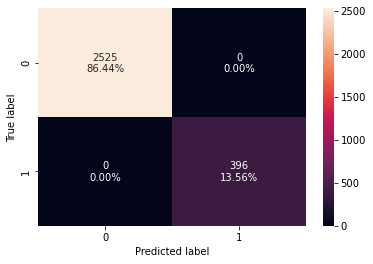

In [87]:
confusion_matrix_sklearn(Model, X_train, y_train)

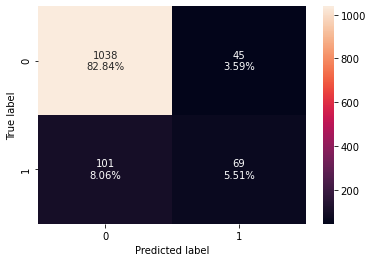

In [88]:
confusion_matrix_sklearn(Model, X_test, y_test)

In [89]:
import pickle as pkl

In [90]:
pkl.dump(Model, open("CustomerMarketing.algo","wb"))

In [91]:
modelloaded = pkl.load(open("CustomerMarketing.algo","rb"))

In [92]:
def model_performance_classification2_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict_proba(X_test)[:,1]>.30

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [93]:
xgb1_test = model_performance_classification2_sklearn(
    Model, X_test, y_test
)
xgb1_test

,Accuracy,Recall,Precision,F1
0,0.874701,0.541176,0.538012,0.539589
